# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [1]:
import torchvision.datasets as ds
import numpy as np

data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

#### Transform the data! ####

In [2]:
import torchvision.datasets as ds
import numpy as np

In [10]:
    def sigmoid(x):    
        return 1. / (1. + np.exp(-x))

    def softmax(x):
        return np.exp(x)/sum(np.exp(x))

### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [21]:
class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions):
        self.w1 = np.random.normal(size=(in_dimensions, hidden_dimensions)) / in_dimensions
        self.b1 = np.random.normal(size=(1,hidden_dimensions)) / in_dimensions
        self.w2 = np.random.normal(size=(hidden_dimensions,out_dimensions)) / in_dimensions
        self.b2 = np.random.normal(size=(1,out_dimensions)) / in_dimensions
    
    def forward(self, x):
        # perform a forward pass of the network and return the result
        # remember to retain the value of each node (i.e. self.h1_forward)
        # in order to use in backpropagation
        # Use whatever activation function you wish for the first layer
        # and softmax activation for the output layer
        #neurons = []
        #for nueron in range(self.l):
        self.x = x
        self.Z_1 = np.dot(x, self.w1) + self.b1
        self.A_1 = sigmoid(self.Z_1)
        self.Z_2 = np.dot(self.A_1, self.w2) + self.b2
        self.A_2 = softmax(self.Z_2)

            
        return self.A_2

    def backward(self, loss, y):
        # perform backpropagation on the loss value and compute the gradient 
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)
        m = self.x.shape[0]
        #second layer derivatives
        #dA = softmax_back((self.A_2 - y), self.Z_2)
        dL_2 = (1./m)*np.matmul(self.A_1.T, self.A_2 - y)
        
        # ones = np.ones((1, dA.shape[0]))
        # db_2 = np.dot(ones, dA)
        db_2 = (1./m)*np.sum(self.A_2 - y, axis=0, keepdims=True)
    
        
        #first layer derivatives
        #dA = softmax_back((self.A_2 - y), self.Z_2)
        dA = np.matmul(self.A_2 - y, self.w2.T) #np.dot((y - yhat) * self.sigmoid_derivative(Xj, self.wjk), self.wjk.T)
        dA_1 = self.A_1*(1. - self.A_1)
        dA = dA*dA_1 
        dL_1 = (1./m)*np.matmul(self.x.T, dA)

        db_1 = (1./m)*np.sum(dA, axis=0, keepdims=True)
        
        return dL_1, dL_2, db_1, db_2

    def step(self, lr, lam, grads, m):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        # don't forget to use regularization
        self.w2 = self.w2 - lr*grads[1] - (lr*lam*self.w2)/m
        self.w1 = self.w1 - lr*grads[0] - (lr*lam*self.w1)/m
        self.b2 = self.b2 - lr*grads[3] 
        self.b1 = self.b1 - lr*grads[2] 
        

In [37]:
target = np.zeros((target_train.shape[0], 10, 1))
target[np.arange(target_train.size), target_train] = 1

### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [17]:
n_epochs = 5 # number of epochs
lr = 0.01# learning rate
k = 5# number of folds
in_dim = 784# MNIST has 28*28 images
hidden_dim = 400# number of hidden dimensions for the hidden layer
out_dim =  10# MNIST has 10 classes
fold_len = int(data_train.shape[0]/k)
lambdas = [0.001, 0.01, 0.1]
best_lambda = lambdas[-1]
best_acc = 0


for l in lambdas:
    acc = 0 # accuracy for current lambda
    loss = 0 # loss for current lambda
    for j in range(k):
        model = MLP(in_dim, hidden_dim, out_dim)
        fold_train_set = np.delete(data_train, np.s_[j*fold_len:(j+1)*fold_len], 0)
        fold_train_target = np.delete(target_train, np.s_[j*fold_len:(j+1)*fold_len], 0)
        val_set = data_train[j*fold_len:(j+1)*fold_len]
        val_target = target_train[j*fold_len:(j+1)*fold_len]

        for i in range(n_epochs):
            # train the model on the data with the curent lambda
            out = model.forward(fold_train_set.reshape(-1,in_dim))
            loss = (1./60000)*np.sum(-np.eye(out_dim)[fold_train_target]*np.log(out))
            accuracy = np.mean(np.argmax(out, axis=1) == fold_train_target)
            # print(loss, accuracy)
            grads = model.backward(loss, np.eye(out_dim)[fold_train_target])
            model.step(lr, l, grads, 60000)

        # test the model on the current validation data
        y_val = model.forward(val_set.reshape(-1,in_dim))
        fold_acc = np.mean(np.argmax(y_val, axis=1) == val_target)
        fold_loss = 0.5*np.sum(np.square(y_val - np.eye(out_dim)[val_target]))
        acc = (acc*(j) + fold_acc) / (j+1)
        loss = (loss*(j) + fold_loss) / (j+1)




    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    print()
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 0.001
Loss: 1206.6836 Accuracy: 0.6157

Lambda: 0.01
Loss: 1206.6820 Accuracy: 0.6053

Lambda: 0.1
Loss: 1206.6849 Accuracy: 0.6241

Best lambda is 0.1 with 0.6241 accuracy


In [177]:
import matplotlib.pyplot as plt

### Part3:
Train a final model using the best lambda on all the training data

In [20]:
n_epochs = 20 # number of epochs
lr = 0.01# learning rate
in_dim = 784# MNIST has 28*28 images
hidden_dim = 100# number of hidden dimensions for the hidden layer
out_dim =  10# MNIST has 10 classes
n_model = MLP(in_dim, hidden_dim, out_dim)# new model
l = 0.1
losses = []
accur = []
for i in range(n_epochs):
      #### training code here ####
        out = n_model.forward(data_train.reshape(-1,in_dim))
        loss = (1./60000)*np.sum(-np.eye(out_dim)[target_train]*np.log(out))
        accuracy = np.mean(np.argmax(out, axis=1) == target_train)
        grads = n_model.backward(loss, np.eye(out_dim)[target_train])
        n_model.step(lr, l, grads, 60000)
        losses.append(loss)
        accur.append(accuracy)
        print(accuracy)

0.05871666666666667
0.27936666666666665
0.40381666666666666
0.4230333333333333
0.42565
0.43283333333333335
0.43128333333333335
0.3856
0.357
0.3552166666666667
0.3339
0.3096333333333333
0.29596666666666666
0.2768333333333333
0.27636666666666665


KeyboardInterrupt: 

In [299]:
accuracy

0.73155

### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

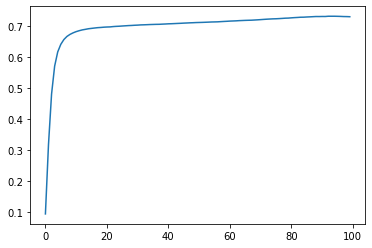

In [300]:
plt.plot(accur)

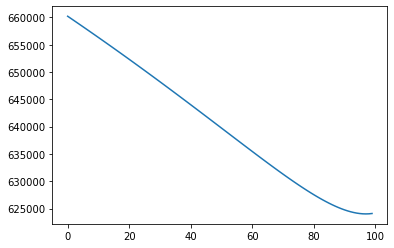

In [301]:
plt.plot(losses)

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [302]:
out = n_model.forward(data_test.reshape(-1,in_dim))
accuracy = np.mean(np.argmax(out, axis=1) == target_test)

In [303]:
accuracy

0.7423

Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.
